### **01. Blob Detection**

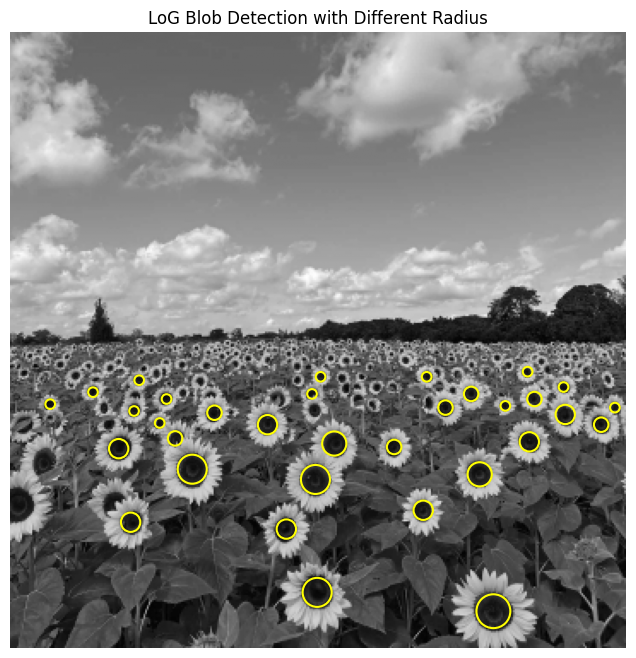

Largest blobs (x, y, radius):
(282, 338, np.float64(9.899494936611665))
(106, 255, np.float64(8.485281374238571))
(178, 261, np.float64(8.485281374238571))
(179, 327, np.float64(8.485281374238571))
(189, 240, np.float64(7.0710678118654755))

Range of σ used: 1.0 to 12.0


In [18]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0


sigma_values = np.linspace(1.0, 12.0, 12)   
scale_space = []

#  Build scale space (LoG filtering at multiple scales)
for sigma in sigma_values:
    hw = int(3 * sigma)
    X, Y = np.meshgrid(np.arange(-hw, hw + 1), np.arange(-hw, hw + 1))
    
    LoG = ((X**2 + Y**2) / (2 * sigma**2) - 1) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    LoG = (LoG / (np.pi * sigma**4)) * sigma**2   
    
    response = cv.filter2D(gray, cv.CV_32F, LoG)
    response = np.square(response)               
    scale_space.append(response)

scale_space = np.stack(scale_space, axis=-1) 
     
# local maxima detection
blobs = []
threshold = 0.1

for s in range(1, len(sigma_values)-1):
    response = scale_space[:, :, s]
    
    for i in range(1, response.shape[0]-1):
        for j in range(1, response.shape[1]-1):
            
            # 3D neighborhood
            local_cube = scale_space[i-1:i+2, j-1:j+2, s-1:s+2]
            if response[i, j] == np.max(local_cube) and response[i, j] > threshold:
                radius = np.sqrt(2) * sigma_values[s]
                blobs.append((j, i, radius))   

# Draw blobs as circles
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(gray, cmap='gray')

for (x, y, r) in blobs:
    circle = plt.Circle((x, y), r, color='yellow', fill=False, linewidth=1.5)
    ax.add_patch(circle)

plt.title("LoG Blob Detection with Different Radius")
plt.axis('off')
plt.show()

# largest blobs
largest = sorted(blobs, key=lambda b: b[2], reverse=True)[:5]
print("Largest blobs (x, y, radius):")
for b in largest:
    print(b)

print("\nRange of σ used:", sigma_values[0], "to", sigma_values[-1])


### **02. RANSAC**

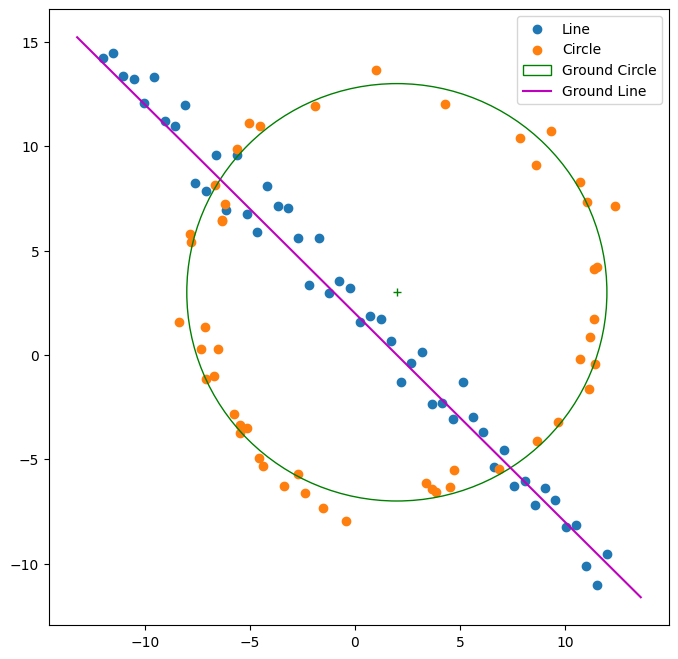

In [3]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16

t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
ax.plot(x_, y_, color='m', label='Ground Line')

plt.legend()
plt.show()



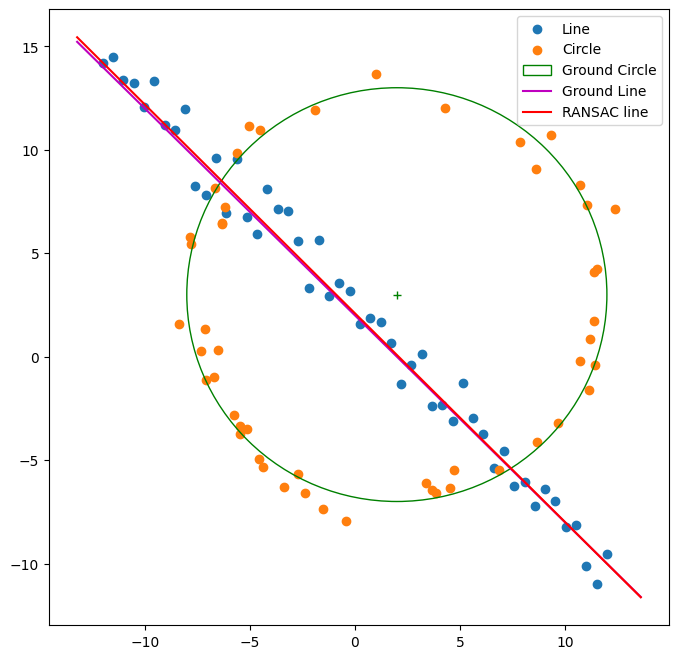

In [ ]:
# RANSAC for Line fitting

num_consensus =20
threshold =0.8
iteration = 100
best_param = None
best_inliers = []

for i in range(iteration):
    idx = np.random.choice(len(X),2, replace = False)
    p1, p2 = X[idx]
    
    # vector of p2-p1
    vec = p2-p1
    normal_vec = np.array([-vec[1],vec[0]])
    normal_vec = normal_vec/np.linalg.norm(normal_vec) # ∥[a, b]⊺∥=1
    
    d = np.dot(normal_vec,p1)
    
    distances = np.abs(X @  normal_vec-d)
    
    inliers = np.where(distances<threshold)[0]
    
    if len(inliers)>len(best_inliers) and len(inliers) >= num_consensus:
        best_inliers = inliers
        best_param = np.array([normal_vec[0], normal_vec[1], d])
        

#plot line
best_a, best_b, best_d =best_param

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_fitted = (best_d-best_a*x_)/best_b

ax.plot(x_, y_, color='m', label='Ground Line')
ax.plot(x_, y_fitted, 'r-', label='RANSAC line')


plt.legend()
plt.show()



    
    

In [ ]:
# RANSAC dor circle fitting
X_remnant = np.delete(X, best_inliers, axis=0)

iteration_circle = 100
best_param_circle = None
best_circle_inliers = []
num_consensus_circle = 20
threshold_circle =0.6

for i in range(iteration_circle):
    idx_circle = np.random.choice(len(X_remnant),3, replace=False)
    p1, p2, p3 = X_remnant[idx_circle]
    
    
